In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [4]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [5]:
sys.path.append("../../fermi-gce-gp/")
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [6]:
ps_mask = np.load("../../fermi-gce-gp/data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

torch.Size([1, 16384, 1])

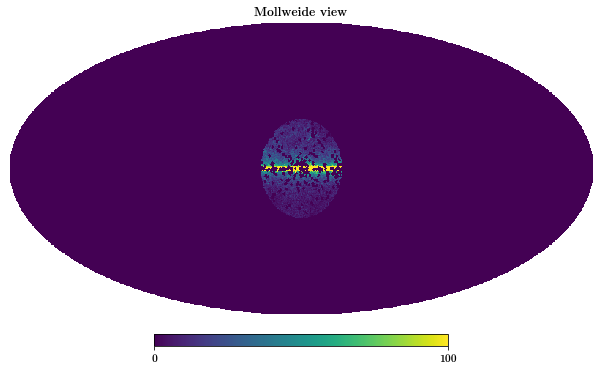

In [7]:
in_map = np.load("../../fermi-gce-gp/data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [9]:
sg = SphericalGraphCNN(nside_list, indexes_list).to(device)

In [10]:
in_map.shape

torch.Size([1, 16384, 1])

In [11]:
in_map = in_map.to(device)

In [12]:
sg(in_map).shape

torch.Size([1, 512])

## Test data generation

In [13]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")

In [14]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [15]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [43]:
from simulations.wrapper import simulator

In [44]:
import sys
sys.path.append("../../sbi/")
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

In [45]:
theta = [3, 10., 1.9, -10., 20., 0.1]
simulator(theta, masks_list[0], temp_gce, pc_inst.psf_r_func)

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [53]:
from tqdm import *

In [54]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.5, 10.0, 1.1, -10.0, 5.0, 0.1]), high=torch.tensor([3.0, 20.0, 1.99, 1.99, 50.0, 4.99]))

In [62]:
np.sum(~masks_list[0])

16384

In [70]:
number_presimulated = 10

theta_presimulated = prior.sample((number_presimulated,))
x_presimulated = [simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func) for theta in tqdm(theta_presimulated)]


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


In [64]:
# theta_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/theta_train.npy")[:100000]
# x_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/x_train.npy")[:100000]

In [65]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [66]:
theta_presimulated[:, 0] = torch.log10(theta_presimulated[:, 0])

In [67]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

## SNPE

In [26]:
from sbi.inference import SNPE

In [27]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = SNPE(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True, show_round_summary=True, 
                           logging_level='INFO',
                         sample_with_mcmc=False,
                         mcmc_method="slice_np",
                         device=device.type)

../../sbi/sbi/inference/base.py:126: UserWarning: You passed some keyword arguments that will not be used. Specifically, the unused arguments are: ['show_round_summary', 'sample_with_mcmc', 'mcmc_method']. These arguments might have been supported in sbi versions <0.14.0. Since 0.14.0, the API was changed. Please consult the corresponding pull request on github: https://github.com/mackelab/sbi/pull/378 and tutorials: https://www.mackelab.org/sbi/tutorial/02_flexible_interface/ for further information.
  f"You passed some keyword arguments that will not be used. "
/Users/smsharma/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/smsharma/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (ty

In [28]:
inference_inst = inference_inst.append_simulations(theta_presimulated, x_presimulated, proposal=prior)
inference_inst._proposal_roundwise

[BoxUniform(Uniform(low: torch.Size([6]), high: torch.Size([6])), 1)]

In [29]:
density_estimator = inference_inst.train(training_batch_size=64, max_num_epochs=50)

In [30]:
posterior = inference_inst.build_posterior(density_estimator)

In [31]:
x_o = x_presimulated[0]
posterior_samples = posterior.sample((1000,), x=x_o)

                        prior support. It may take a long time to collect the remaining
                        927 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


In [71]:
from tqdm.auto import tqdm

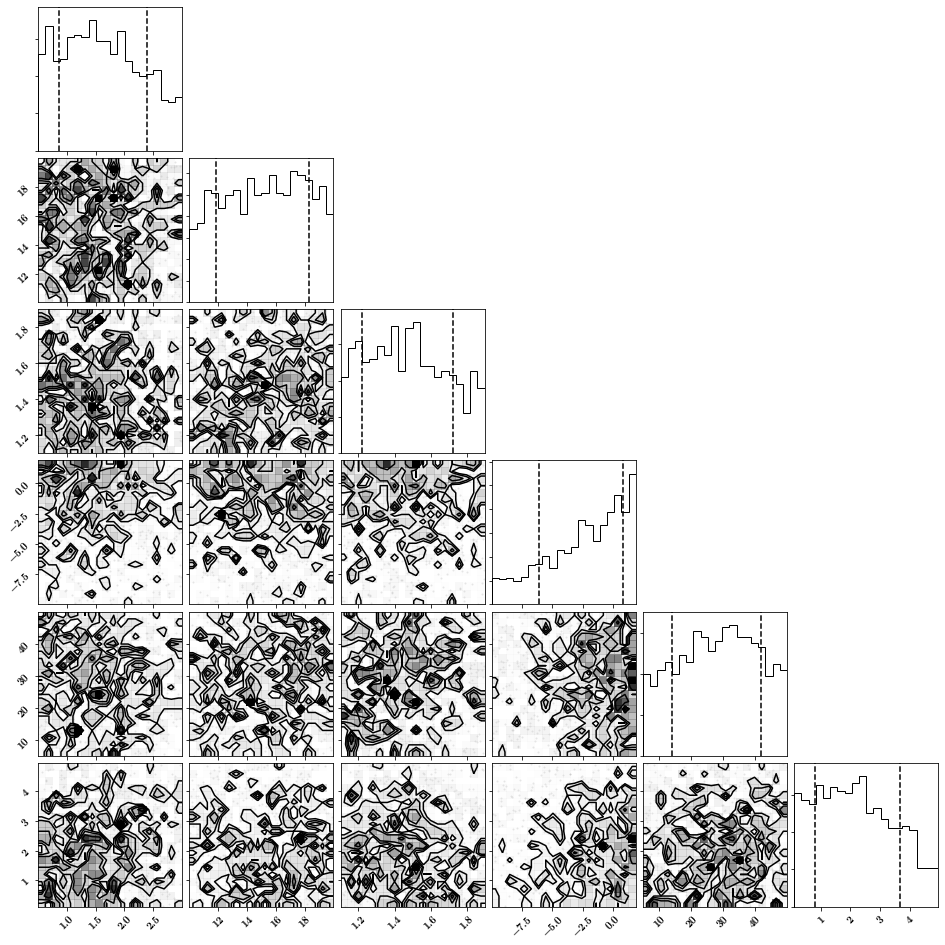

In [33]:
import corner
corner.corner(posterior_samples, quantiles=(0.16, 0.84));